# Portfolio withdrawal analysis

In this Notebook I will analyse how much money I can safely withdraw from the day I retire until my death.

In this experiment I have several groups of hypothetical investors, each with an portfolio worth *portfolio_start_value* SEK the moment they decide to retire. Each group is alloted to one of the following portfolios:

- **Stocks/Bonds 20/80** - 20% in US stocks and 80% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 40/60** - 40% in US stocks and 60% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 60/40** - 60% in US stocks and 40% in short-, mid- and longterm US Treasury bonds
- **Stocks/Bonds 80/20** - 80% in US stocks and 20% in short-, mid- and longterm US Treasury bonds
- **Harry Brownes Permanent Portfolio** - 25% in US stocks, 50% in short- and longterm US Treasury bonds and 25% in gold 
- **US Stocks** - 100% in US stocks
- **Gold** - 100% in gold

Each group is made up of 102 hypothetical investors:

- **The first investor in each group retires in 1871**
- **The second investor in each group retires in 1872**
- **The third investor in each group retires in 1873**
- **And so on until the 102th investor in each group that retires in 1973**

In this Notebook I want to answer the following questions:

- Which portfolio is the safest?
- How much can I safely withdraw from my portfolio each year after retirement?

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from os import path
from datetime import datetime, timedelta
from scipy.stats import norm

In [3]:
def convert_yearly_return_to_numeric(yearly_return_string):
    
    #Check if it is a positive return
    if '+' in yearly_return_string:
        yearly_return_string = yearly_return_string.replace('+', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 + yearly_return_numeric)/100
        
    else:
        yearly_return_string = yearly_return_string.replace('-', '')
        yearly_return_numeric = float(yearly_return_string)
        yearly_return_numeric = (100 - yearly_return_numeric)/100
    
    return yearly_return_numeric
    

In [4]:
def find_yearly_returns(soup):
    
    result = []
    
    html_table = soup.find('table', id='yearReturns')
    html_table_tbody = html_table.find('tbody')
    html_table_tbody_rows = html_table_tbody.findAll('tr')
    
    for row in html_table_tbody_rows:
        current_year = row.find('td').text
        total = convert_yearly_return_to_numeric(row.find_all('td')[1].text)
        inflation_adjusted = convert_yearly_return_to_numeric(row.find_all('td')[2].text)
        result.append({'year': current_year, 'inflation_adjusted': inflation_adjusted, 'total': total})
        
    return result

In [5]:
def fetch_portfolio_results(portfolio_name):
    base_url = "http://www.lazyportfolioetf.com/allocation"
    portfolio = "stocks-bonds-60-40"
    url = f"{base_url}/{portfolio_name}/"

    req = requests.get(url)
    soup = BeautifulSoup(req.text, "html.parser")
    
    df = pd.DataFrame(find_yearly_returns(soup))
    df['year'] = pd.DatetimeIndex(df['year']).year

    return df

In [6]:
def read_portfolio_results(portfolio_name):
    
    file = r'data/' + portfolio_name + '.csv'
    
    try:
        df = pd.read_csv(file, index_col=None, header=0)
        return df
    except:
        print(f"Data for portfolio {portfolio_name} not found locally...Will scrape it from Lazy ETF")
        df = fetch_portfolio_results(portfolio_name)
        df.to_csv(f"data/{portfolio_name}.csv")
        return df

# Start simulations
Run simulations for withdrawing n % of money from the portfolio each year

In [7]:
#Set start date, number of years, withdrawal rate, etc.
start_year = datetime(1871, 1, 1).year
end_year = datetime(1972,1 , 1).year
withdrawal_rates = [0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
number_of_years_to_withdraw = 50
portfolio_start_value = 500000

portfolios = ['stocks-bonds-40-60', 'stocks-bonds-60-40', 'stocks-bonds-80-20', 'harry-browne-permanent', 'us-stocks', 'gold', 'stocks-bonds-20-80']

In [8]:
def forward_fill_portfolio_value(df, start_year, end_year, withdrawal_rate, portfolio_start_value):
    for i in range(start_year, end_year + 1):
        df.loc[i, 'portfolio_value'] = (df.loc[i-1, 'portfolio_value'] * df.loc[i, 'inflation_adjusted'])
        df.loc[i, 'portfolio_value'] = df.loc[i, 'portfolio_value'] - (portfolio_start_value * withdrawal_rate)
    df = df.set_index(df['year'])
    return df

In [9]:
def withdraw_for_n_years(df, start_year, end_year, withdrawal_rate, portfolio_start_value, portfolio_name):
    
    df = df[df['year'] <= end_year]
    df = df[df['year'] >= start_year]
    df = df.set_index(df['year'])

    df.loc[start_year, 'portfolio_value'] = portfolio_start_value
    df = forward_fill_portfolio_value(df, start_year + 1, end_year, withdrawal_rate, portfolio_start_value)
    #display(df)
    df = df[df['portfolio_value'] >= (portfolio_start_value * withdrawal_rate)]
    #years_survived = relativedelta(df['Date'].iloc[-1], df['Date'].iloc[0]).years
    
    if(len(df) == 0):
        return {"start_date": start_date, "end_date": None, "years_survival": 0}
    
    return {"start_date": df.iloc[-1]['year'], "end_date": df.iloc[0]['year'], "years_survival": len(df) - 1, "portfolio_end_value": df.iloc[0]['portfolio_value'], "portfolio_name": portfolio_name, "withdrawal_rate": withdrawal_rate}

In [ ]:
result = []

for withdrawal_rate in withdrawal_rates:
    
    print(f"Running simulations with withdrawal rate: {withdrawal_rate * 100}%")

    for portfolio_name in portfolios:
  
        print(f"Running simulations on portfolio: {portfolio_name}")
    
        df = fetch_portfolio_results(portfolio_name)

        for current_year in range(start_year, end_year):
    
            result.append(withdraw_for_n_years(df, current_year, current_year + number_of_years_to_withdraw, withdrawal_rate, portfolio_start_value, portfolio_name))
    
results_df = pd.DataFrame(result)
print(f"\033[1mSimulation is finished!\033[0m")

Running simulations with withdrawal rate: 2.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 2.5%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80-20
Running simulations on portfolio: harry-browne-permanent
Running simulations on portfolio: us-stocks
Running simulations on portfolio: gold
Running simulations on portfolio: stocks-bonds-20-80
Running simulations with withdrawal rate: 3.0%
Running simulations on portfolio: stocks-bonds-40-60
Running simulations on portfolio: stocks-bonds-60-40
Running simulations on portfolio: stocks-bonds-80

In [52]:
print(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'years_survival' : ['mean', 'min', 'max', 'median']}).to_string())
print(results_df.groupby(['portfolio_name', 'withdrawal_rate']).agg({'portfolio_end_value' : ['mean', 'min', 'max', 'median']}).to_string())

                                       years_survival               
                                                 mean min max median
portfolio_name         withdrawal_rate                              
gold                   0.020                41.396040  27  50     45
                       0.025                36.594059  22  50     36
                       0.030                32.267327  18  50     31
                       0.035                28.772277  15  50     27
                       0.040                25.752475  14  50     24
                       0.050                20.772277  11  50     18
                       0.060                17.188119   9  50     15
                       0.070                14.376238   7  38     12
                       0.080                12.316832   6  31     10
                       0.090                10.683168   5  29      9
                       0.100                 9.465347   5  27      8
harry-browne-permanent 0.020      

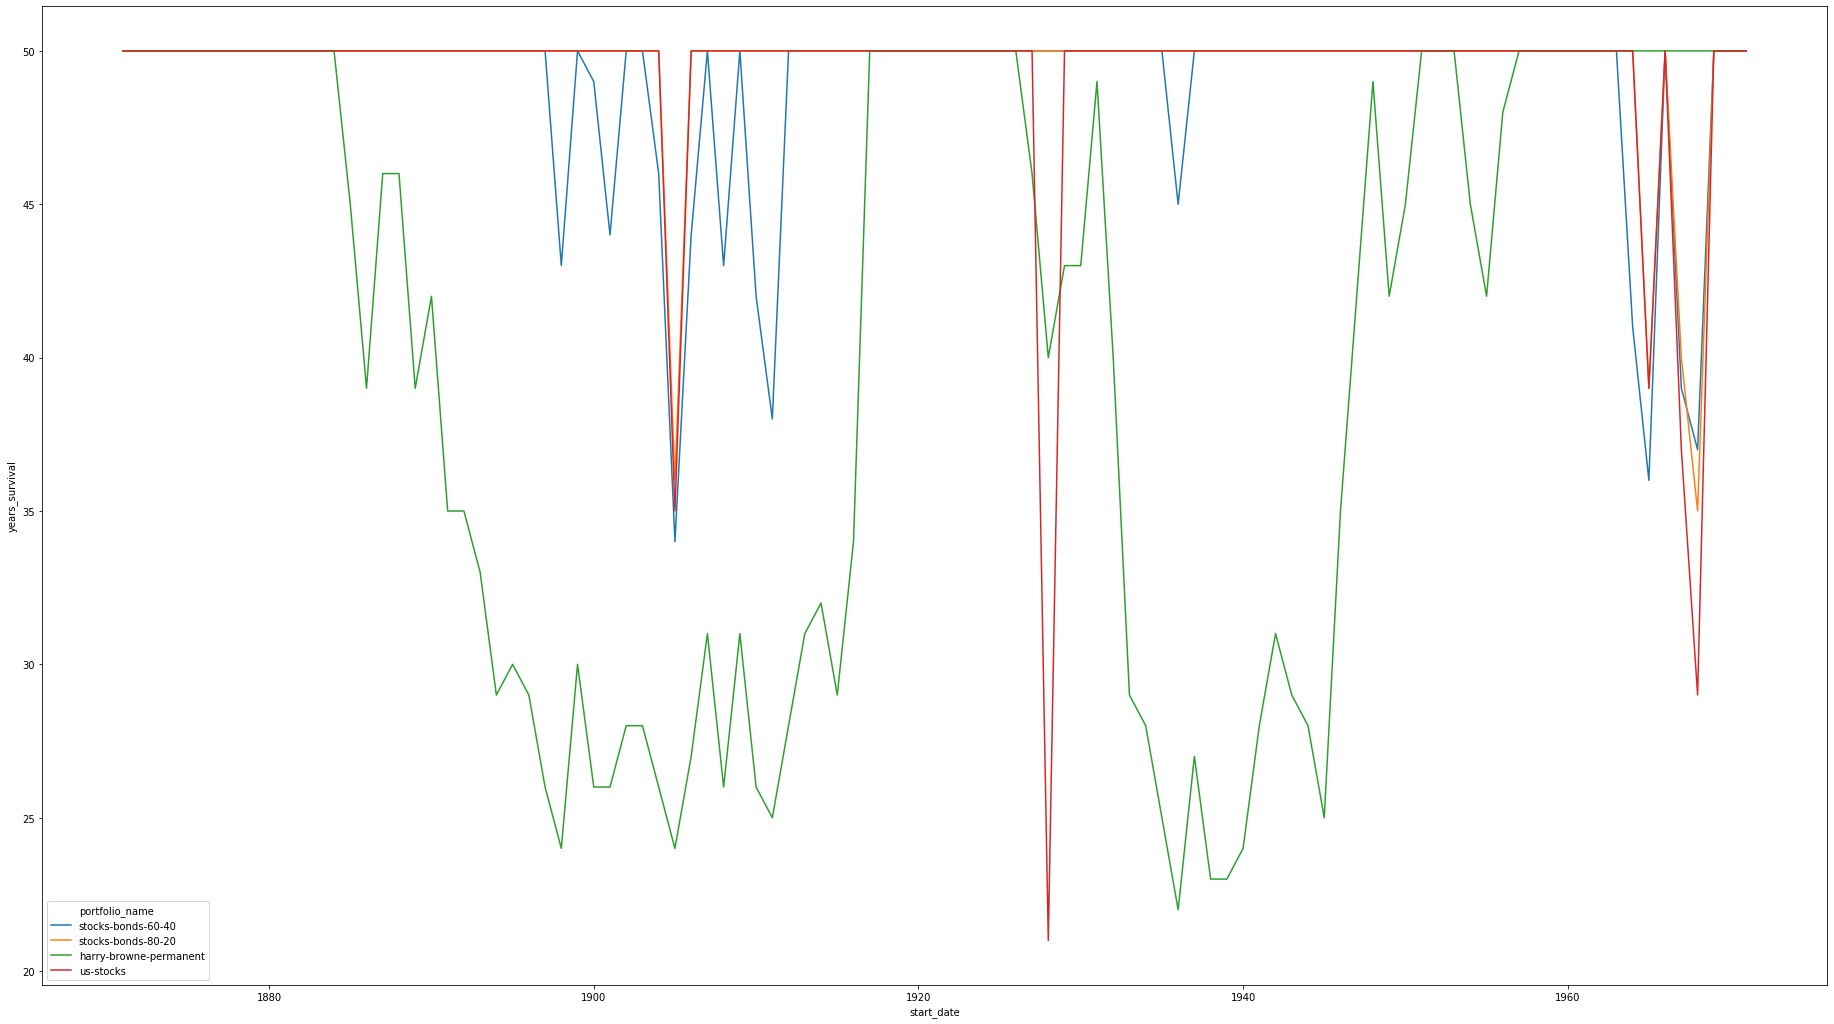

In [78]:
df_to_plot = results_df[(results_df['withdrawal_rate'] == 0.04) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'us-stocks', 'stocks-bonds-60-40', 'harry-browne-permanent']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df_to_plot) 
plt.show()

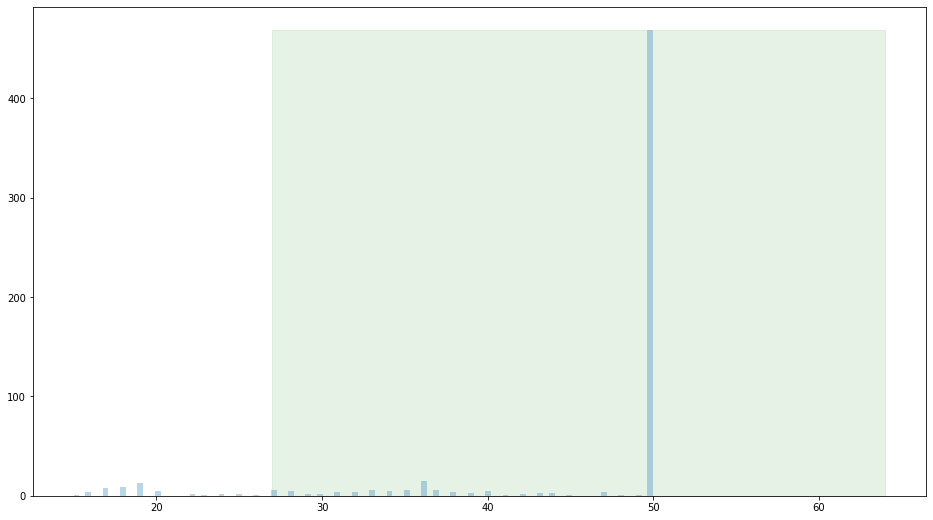

In [288]:
test_df = results_df
arr = test_df['years_survival']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)

# Results

Here are the results from the simulations

## Being safe and never risking running out of money

If your objective is to be as safe as possible and have a *very* little risk of running out of money in your portfolio during your retirement years these are the level of withdrawal rates and portfolios you should consider.

Withdrawal rate: <= 3.5%

The graph below shows the longetivitiy of the different portfolios on the y-axis and the year of retirement on the x-axis. As you can see the following portfolios are the safest:

- Stocks/Bonds 80/20
- Stocks/Bonds 60/40
- US Stocks

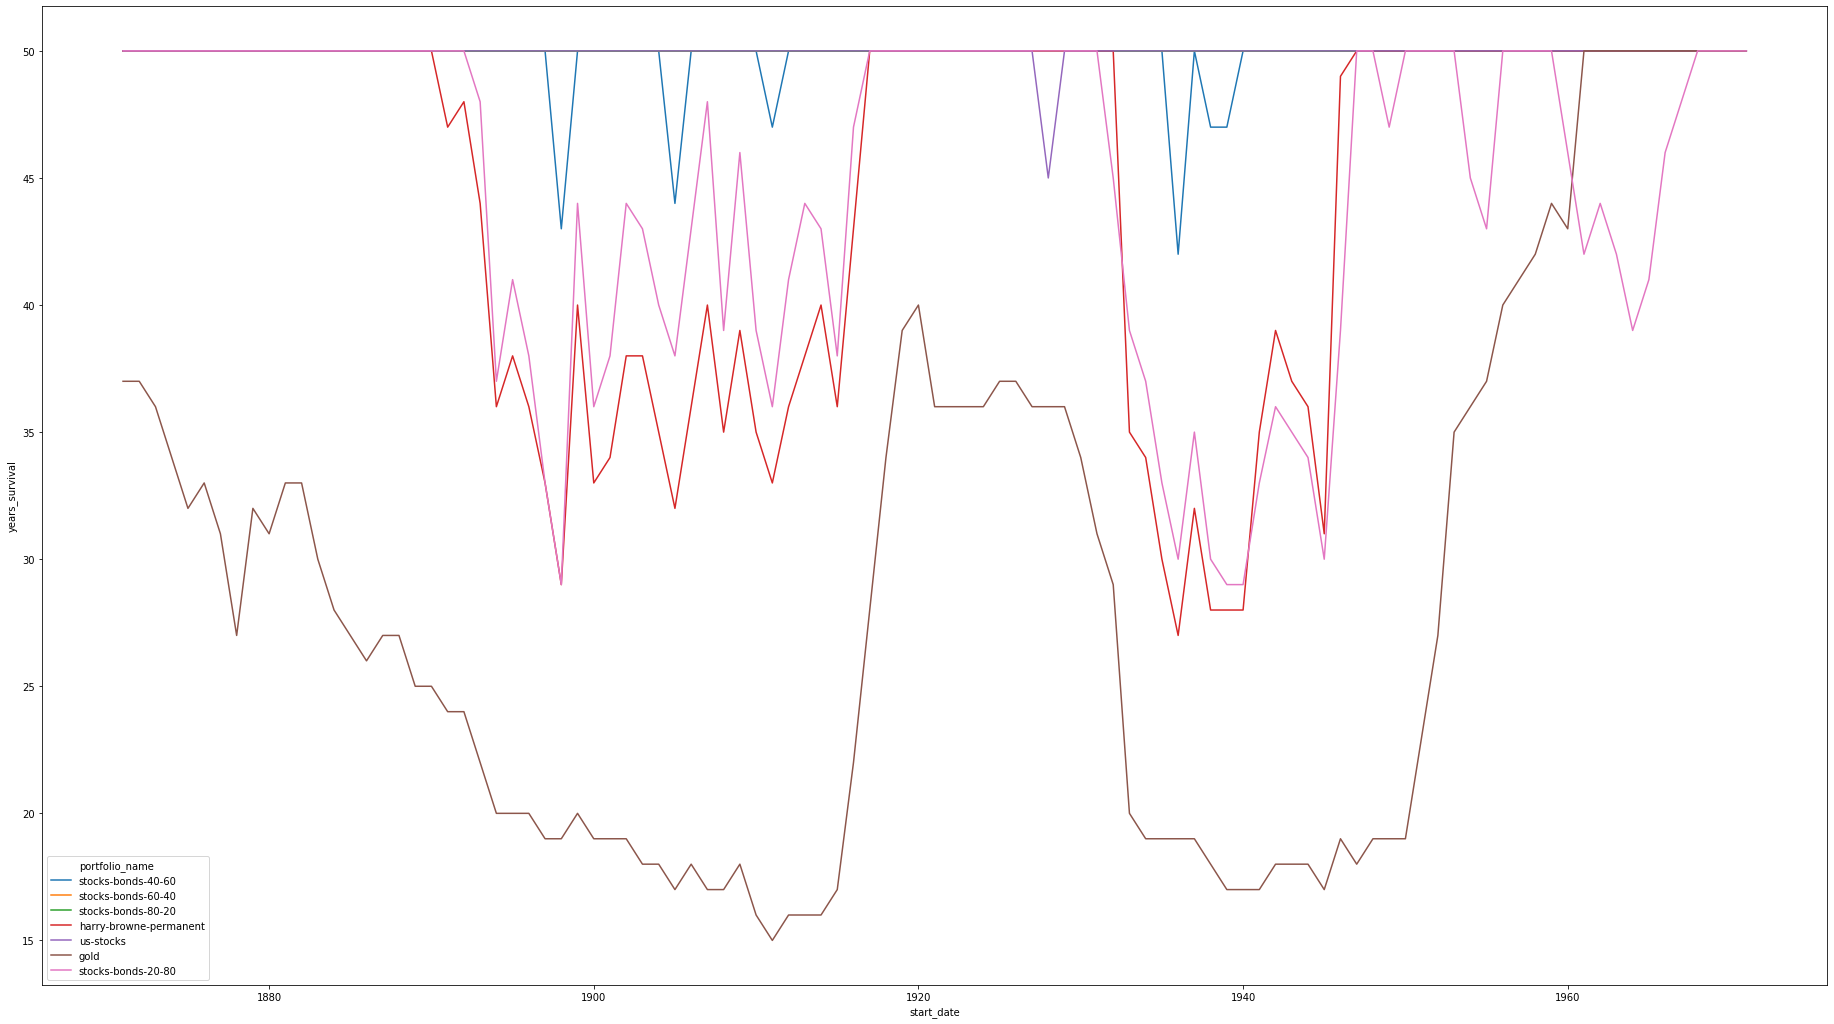

In [80]:
df1 = results_df[(results_df['withdrawal_rate'] == 0.035)]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df1) 
plt.show()

Lets look at the same graph but with only the three top-performing portfolios visible:

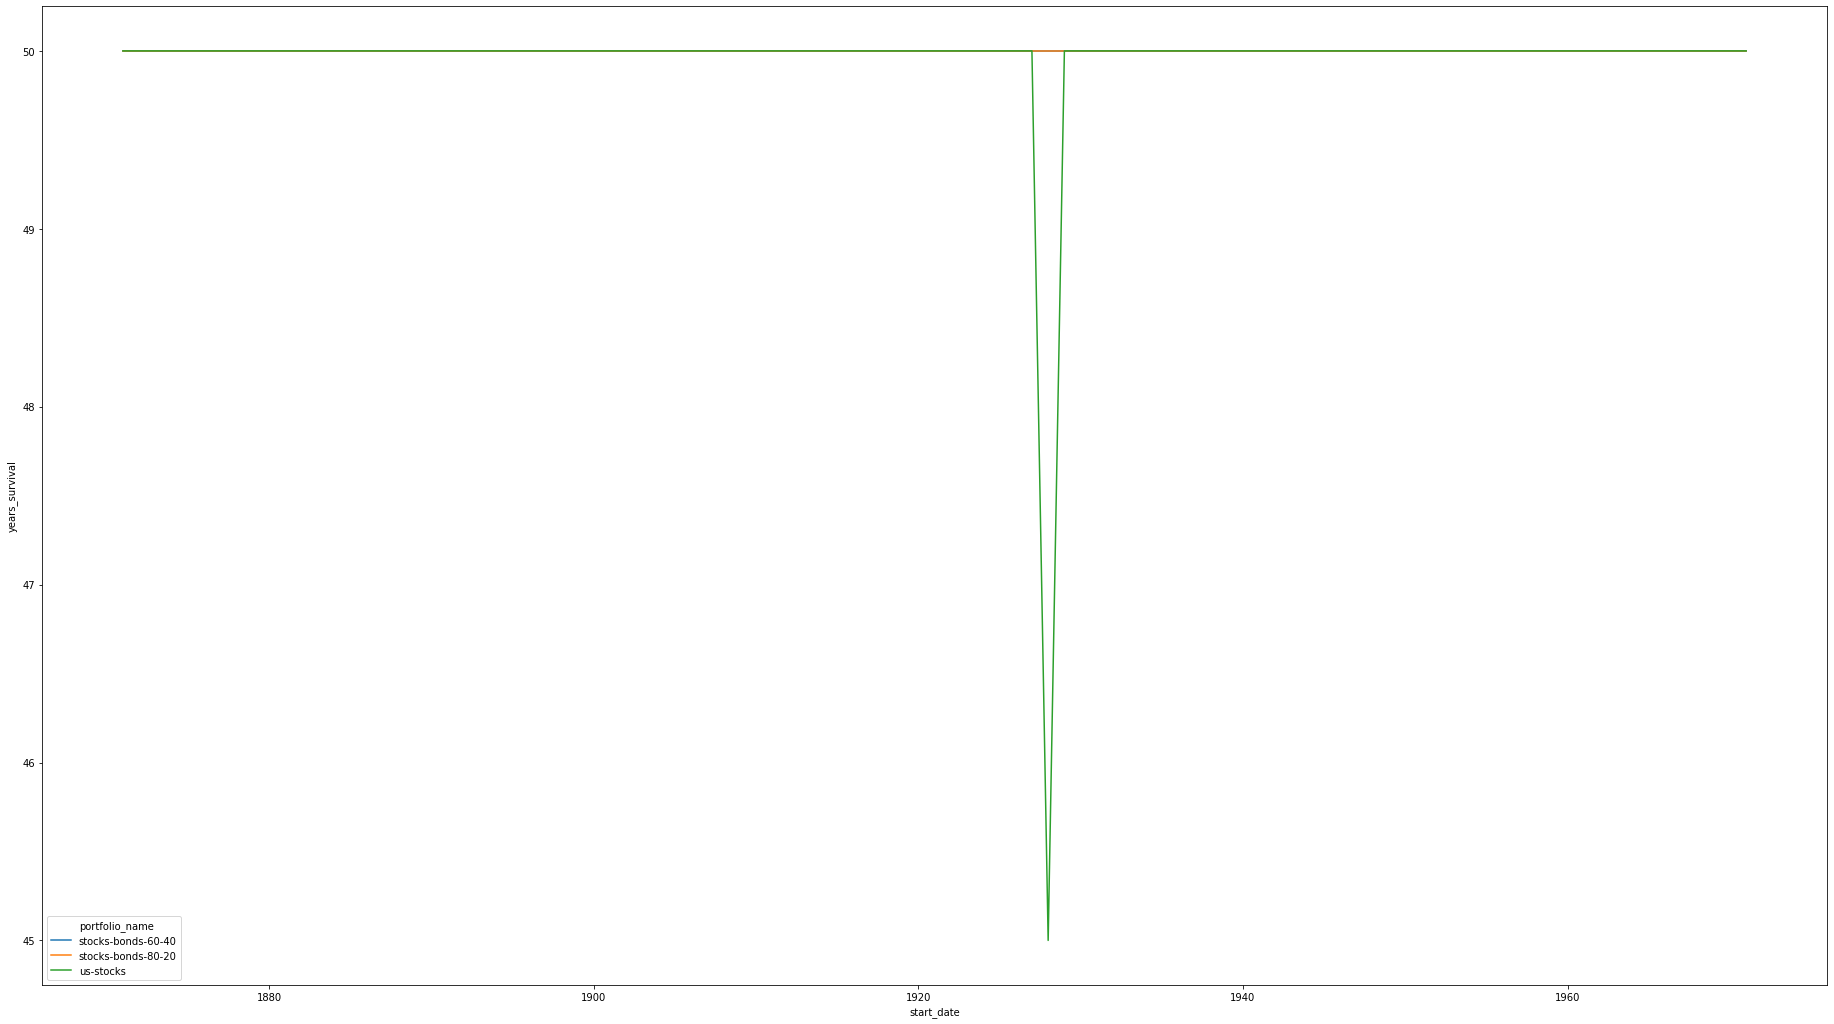

In [83]:
df2 = results_df[(results_df['withdrawal_rate'] == 0.035) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df2) 
plt.show()

As you can see, almost all investors could safely withdraw 3.5% a year from their portfolios for 50 years - **With a few exceptions**:

The investors that retired in the end of the great bull market of the 1920s (right before the crash of 1929) would run out of money after 45 years instead of 50. Having 20-40% of their portfolios in US Treasury bonds shielded all bond-holding investors from that crash.

Having a stock market crash early in your retirement years is very terminal to your wealth as we can see in this graph - The portfolio of these investors really never recovered after the crash of 1929.

But running out of money 5 years earlier than expected perhaps is not so bad? What if we try to increase the annual withdrawal rate from 3.5% to 4%? The graph below shows this scenario:

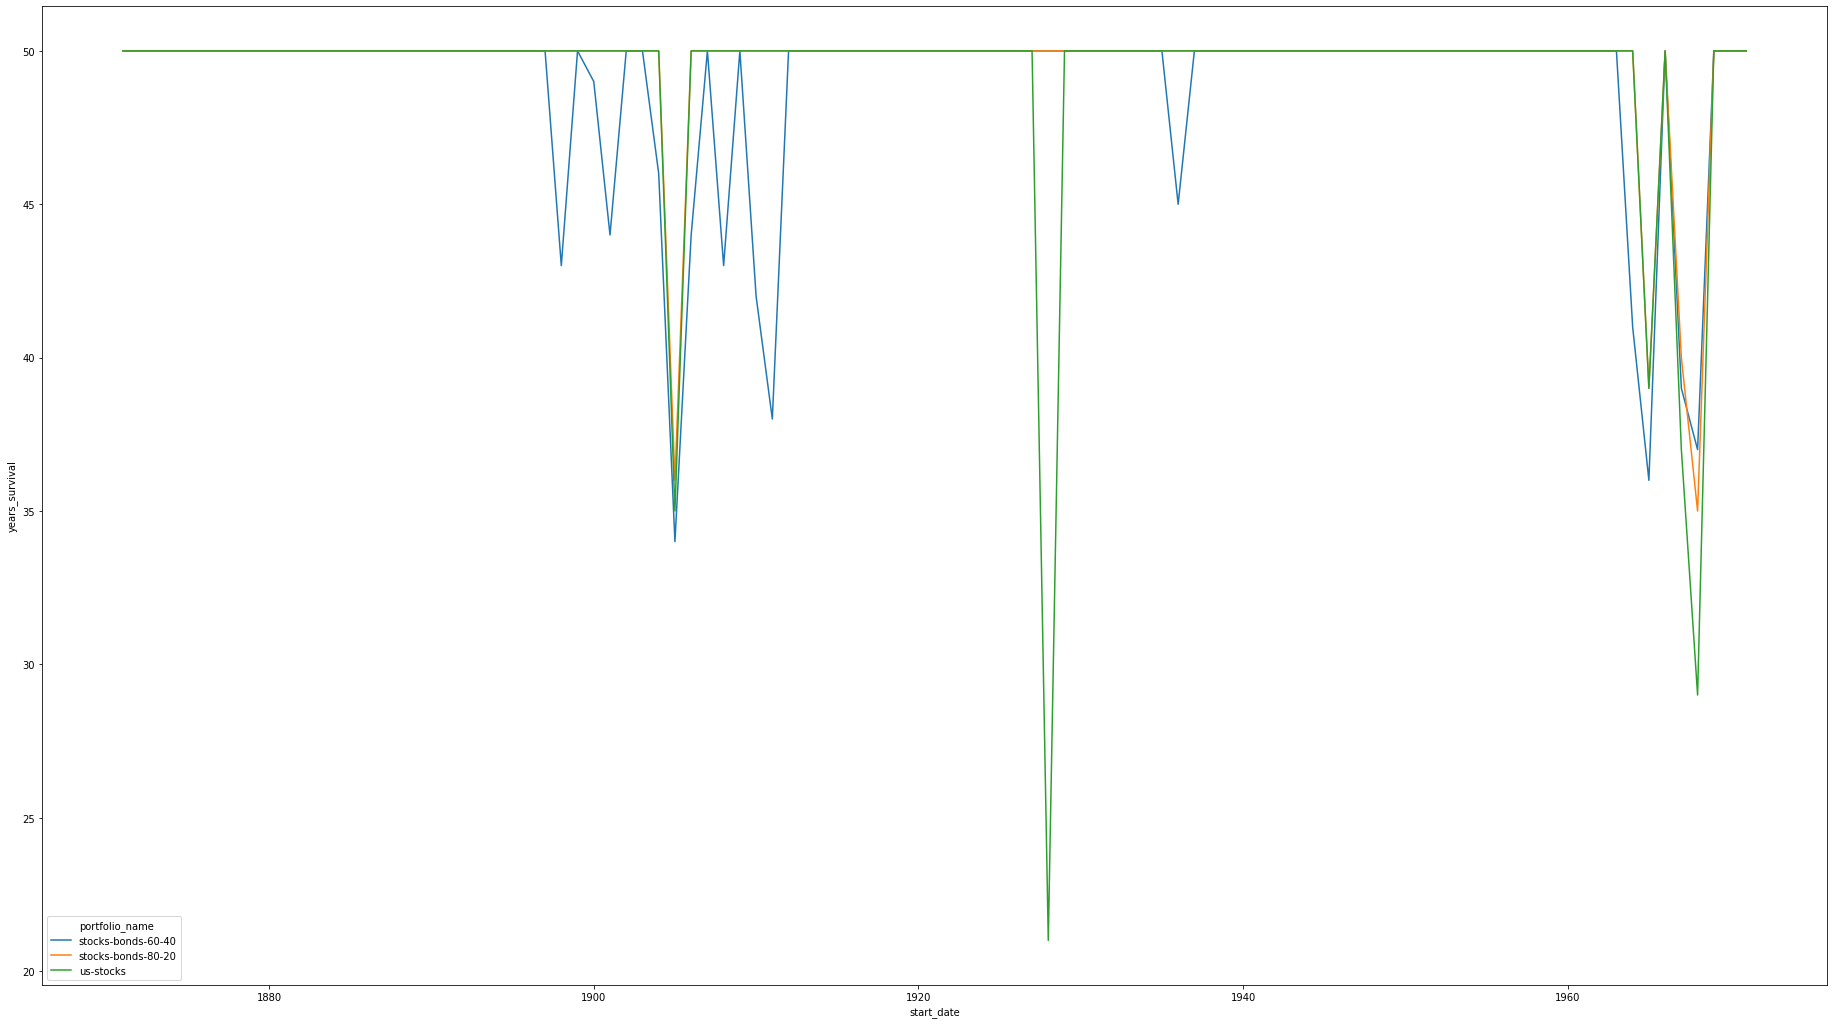

In [84]:
df3 = results_df[(results_df['withdrawal_rate'] == 0.04) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df3) 
plt.show()

From this graph we can make a few conclusions:

- Having a higher share of US Treasury bonds in the portfolio is negative - In the late last decade of the 19th century and the first decade of the 20th century owning too much bonds proved to be a bad thing. The same goes for the 1930s and the 1970s. This is probably because a lower share of US stocks means that these investors missed out on many large stock moves. Even in market crashes the 60/40-portfolio underperformed, probably because this portfolio failed to regain the lost ground in the following bull markets.
- The US Stock portfolio ran out of money after just 20 years for the unlucky retirees who retired right before the 1929 market crash. The portfolio had to withstand a larger withdrawal rate (4% compared to 3.5% in the previous graph) as well as the greatest stock market crash in history and this proved to be too much for the portfolio, severely affecting it's life expectancy.
- All portfolios had a reduced life expectancy at the turn of the 20th century. The stock market flatlined for almost two decades during this period and withdrawing as much as 4% annually of their portfolios shortened the life-length of the **US Stock** and **80/20** portfolios by 10 years. The same goes for the late 1960s and early 1970s - The investors retiring during this period would face another lost decade of the stock market, high inflation and low bond yields.
- The safest portfolio appears to be the **Stock/Bond 80/20 portfolio** - Almost all investors who used this portfolio would live for 50 years without ever running out of money the exceptions being the poor investors who happened to retire in the early 20th century or the late 1960s/early 1970s.

What if we increased the withdrawal rate even a bit more? Maybe, with a little bit of luck we would be able to avoid retiring in the worst of years thus increasing our withdrawal rates - The graph below show the portfolio life-lenghts for a 5% withdrawal rate:

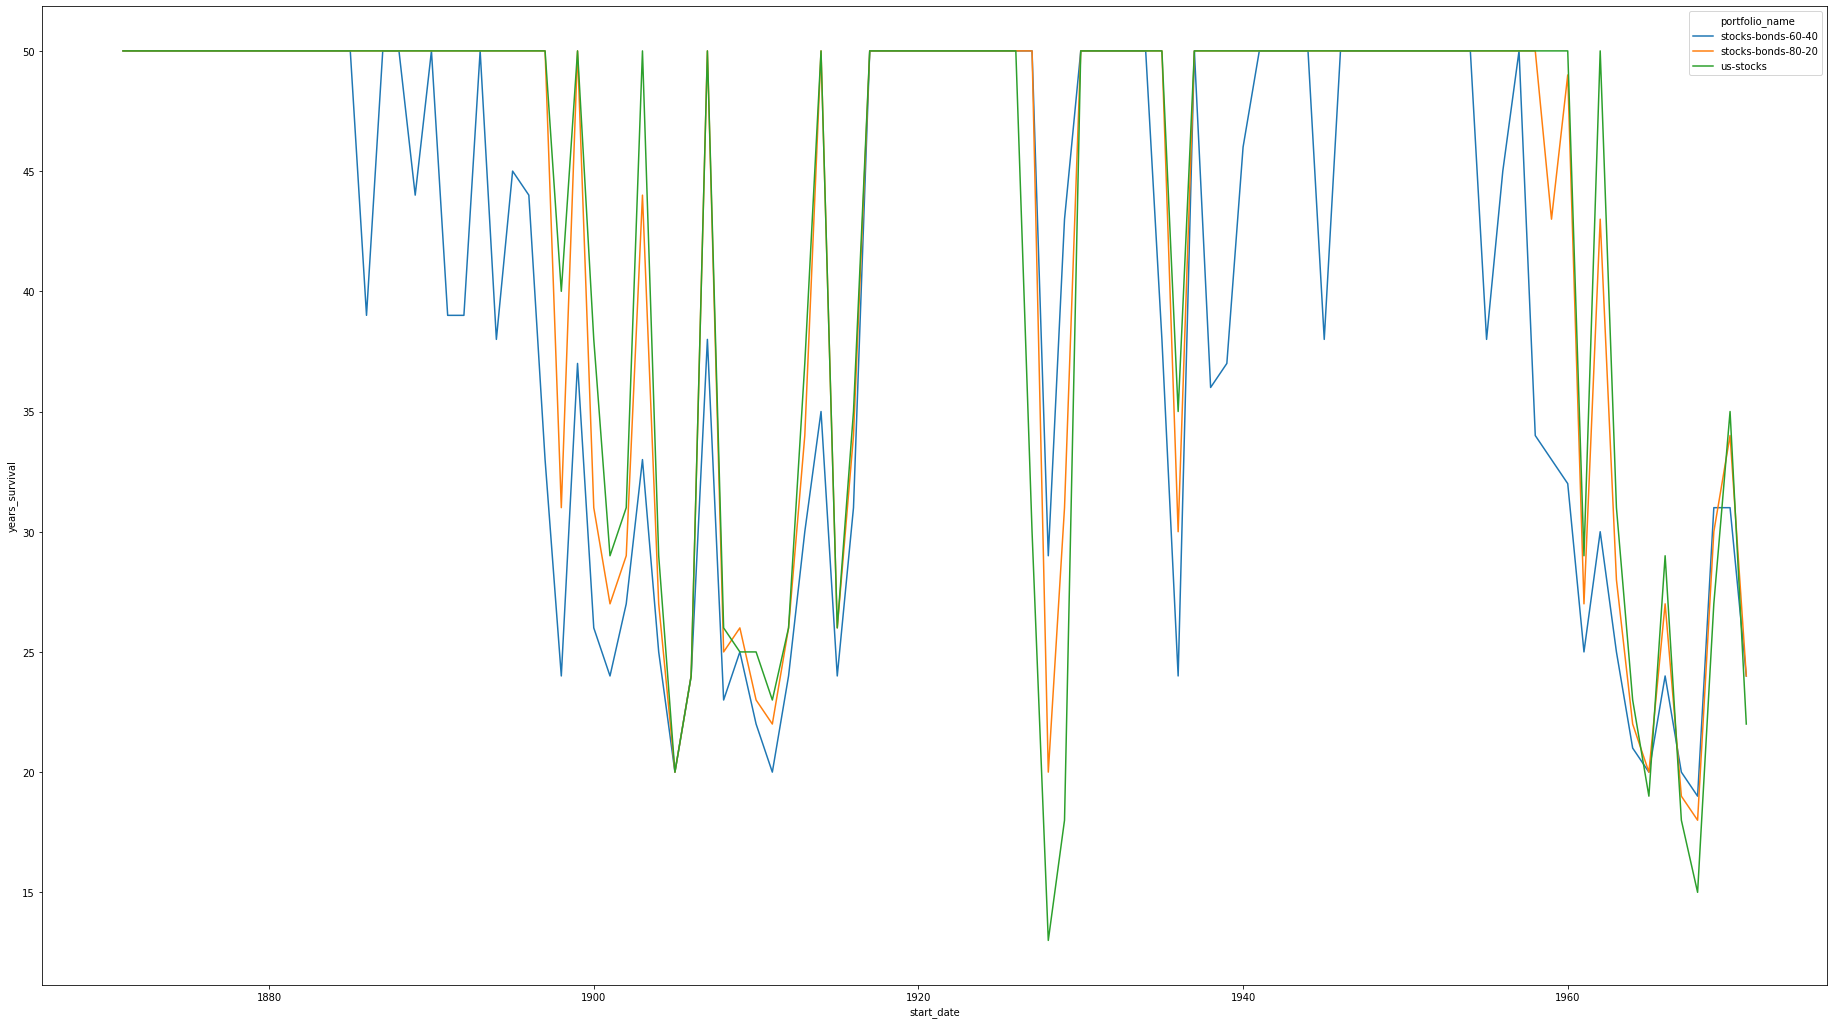

In [92]:
df4 = results_df[(results_df['withdrawal_rate'] == 0.05) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df4) 
plt.show()

In this scenario it is the **US Stock** portfolio that outperforms. Except for the investors the retired right before the 1929 crash (they would run out of money after just 12 years) the investors who held a 100% US Stock portfolio would be best of. This is probably because the stock markets re-generative properties are much needed when the investors withdraws too much from their portfolios. The portfolios containing US Treasury bonds are never given the time to catch up after stock market crashes and therefore they will underperform (except in the 1929 crash when these portfolios would add another 10-20 years of economic freedom to their holders compared to the US Stock portfolio).

There is roughly a 50/50 chance that the investors who chooses to withdraw 5% annually can live happily without running out of money - If they are invested in at least 80% US stocks and as long as they didn't retire in the periods 1890-1915, right before the ourbreak of World War 2 or the 1970s.

In [1]:
df4 = results_df[(results_df['withdrawal_rate'] == 0.05) & (results_df['portfolio_name'].isin(['stocks-bonds-80-20', 'stocks-bonds-60-40', 'us-stocks']))]
fig, ax = plt.subplots(figsize=(32,18))
sns.lineplot(x='start_date', y='years_survival', hue='portfolio_name', data=df4) 
plt.show()

NameError: name 'results_df' is not defined